In [97]:
import numpy as np
import random
import matplotlib.pyplot as plt

import gym
import gym.envs.toy_text
env = gym.envs.toy_text.CliffWalkingEnv()
n_actions = env.action_space.n

print(env.__doc__) # 출력화면으로 대략적인 cliff walking 문제의 정보를 확인


    This is a simple implementation of the Gridworld Cliff
    reinforcement learning task.

    Adapted from Example 6.6 (page 106) from Reinforcement Learning: An Introduction
    by Sutton and Barto:
    http://incompleteideas.net/book/bookdraft2018jan1.pdf

    With inspiration from:
    https://github.com/dennybritz/reinforcement-learning/blob/master/lib/envs/cliff_walking.py

    The board is a 4x12 matrix, with (using NumPy matrix indexing):
        [3, 0] as the start at bottom-left
        [3, 11] as the goal at bottom-right
        [3, 1..10] as the cliff at bottom-center

    Each time step incurs -1 reward, and stepping into the cliff incurs -100 reward
    and a reset to the start. An episode terminates when the agent reaches the goal.
    


In [98]:
print('Possible action',env.action_space.n)
env.render()# environment를 텍스트로 출력

Possible action 4
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
x  C  C  C  C  C  C  C  C  C  C  T



### RL training main code cell -> do not run!

In [99]:
s = env.reset() # environment 초기화 
total_reward = 0.
t_max = 10**4

for t in range(t_max): # 매 에피소드마다 무한정 반복할수 없으니 적정선에서 끊는다.
    # <구현 필! SARSA, Q_learning agent에 맞게 action추출>
    
    new_s, reward, done, _ = env.step(a) # agent의 action을 환경에 대입하고 s', R을 관찰
    # <구현 필! SARSA, Q_learning agent학습 시행>
    
    s = new_s # state swap
    total_reward += r # 누중합
    
    if done: # 목표에 도달했거나 절벽에 떨어졌다면 에피소드 종료
        break

NameError: name 'a' is not defined

In [105]:
class SARSA_agent():
    def __init__(self,alpha=0.25,epsilon=0.2,gamma=0.99,possible_actions=range(n_actions)):
        '''
        class 입력인자
         - alpha : 학습률 learning rate
         - epsilon: epsilon, epsilon-greedy exploration
         - gamma: 할인율, discount factor
         - possible_actions: 선택할수있는 a의 옵션, cliff-walking: 'up,left,down,right' 
         
        SARSA agent 업데이트 알고리즘
         - ***Epsilon-greedy*** 방식을 도입해 $a$를 취한다.
         - $a$로부터 $s', R$을 관찰한다.
         - ***Epsilon-greedy*** 방식을 도입해 $s'$로 부터 $a'$를 취한다. 
         - $Q(s,a) \leftarrow Q(s,a) + \alpha \left \{ R+\gamma Q(s',a') - Q(s,a) \right \}.$
         - $s \leftarrow s'$, $a \leftarrow a'$ 로 업데이트
         
        필수기능
          - agent update(s,a,r,s') -> for update
          - agent get_action(s) -> state로부터 action추출(Epsilon greedy)
        부수기능
          - agent get_qvalue(s, a) -> state, action으로 부터 Q_function값 추출
          - agent get_values(s) -> state로부터 Value-function값 추출
        '''
        self.alpha = alpha
        self.epsilon = epsilon
        self.gamma = gamma
        self.possible_actions=possible_actions
        self._qvalue = {}
    '----------------------------------------------------필수기능'
    def update(self,state,action,reward,next_state):
        # Q_update는 코딩상 다음과 같이 계산해준다
        # Q(s,a) = (1-alpha)*Q(s,a)+alpha*(reward + gamma*V(s')) 
        # V(s')는 최적의 action-value Q(s',a')를 대용하기 때문
        q_update = (1-self.alpha)*self.get_qvalue(state,action)+self.alpha*(reward+self.gamma*self.get_value(next_state))
        self.set_qvalue(state,action,q_update)
        
    def get_action(self,state):
        '''
        SARSA epsilon-greedy
        '''
        p = np.random.uniform(0,1)
        if p<=self.epsilon:
            best_action = random.choice(self.possible_actions)
        else:
            best_action = random.choice(self.possible_actions)
            best_qvalue = self.get_qvalue(state,best_action)
            for possible_action in self.possible_actions:
                if self.get_qvalue(state,possible_action) >= best_qvalue:
                    best_action = possible_action
                    best_qvalue = self.get_qvalue(state,possible_action)
        return best_action
        
    '----------------------------------------------------부수기능'    
    def set_qvalue(self,state,action,value):
        if state not in self._qvalue: #초기화
            self._qvalue[state] = {}
            for possible_action in self.possible_actions:
                self._qvalue[state][possible_actiosn]=0
        else:
            self._qvalue[state][action]=value
    
    def get_qvalue(self,state,action):
        if state not in self._qvalue: #초기화
            self._qvalue[state] = {}
            for possible_action in self.possible_actions:
                self._qvalue[state][possible_action] = 0
        return self._qvalue[state][action]
    
    def get_value(self,state):
        '''
        epsilon-greedy방식을 기반으로 Value값을 추산
        
        SARSA
            Q(s',a') ~ V(s')
        policy 
            if action == argmaxQ(s,a)
                policy[action] = eps/m + 1-eps
            else
                policy[action] = eps/m
                
        Remind V(s) = sum_a { policy(a|s)*Q(s,a)}
        '''
        state_value = 0
        policy = np.ones(len(self.possible_actions))*self.epsilon/len(self.possible_actions)
        best_action = 0
        max_val = self.get_qvalue(state,self.possible_actions[best_action])
        for idx, possible_action in enumerate(self.possible_actions):
            if max_val <= self.get_qvalue(state,possible_action):
                best_action = idx
                max_val = self.get_qvalue(state,possible_action)
        policy[best_action] += 1-self.epsilon
        for idx,possible_action in enumerate(self.possible_actions):
            state_value += self.get_qvalue(state,possible_action)*policy[idx]
        return state_value

In [106]:
class Off_Q_agent():
    def __init__(self,alpha=0.25,epsilon=0.2,gamma=0.99,possible_actions=range(n_actions)):
        '''
        class 입력인자
         - alpha : 학습률 learning rate
         - epsilon: epsilon, epsilon-greedy exploration
         - gamma: 할인율, discount factor
         - possible_actions: 선택할수있는 a의 옵션, cliff-walking: 'up,left,down,right' 
         
        SARSA agent 업데이트 알고리즘
         - ***Epsilon-greedy*** 방식을 도입해 $a$를 취한다.
         - $a$로부터 $s', R$을 관찰한다.
         - ***Epsilon-greedy*** 방식을 도입해 $s'$로 부터 $a'$를 취한다. 
         - $Q(s,a) \leftarrow Q(s,a) + \alpha \left \{ R+\gamma Q(s',a') - Q(s,a) \right \}.$
         - $s \leftarrow s'$, $a \leftarrow a'$ 로 업데이트
         
        필수기능
          - agent update(s,a,r,s') -> for update
          - agent get_action(s) -> state로부터 action추출(Epsilon greedy)
        부수기능
          - agent get_qvalue(s, a) -> state, action으로 부터 Q_function값 추출
          - agent get_values(s) -> state로부터 Value-function값 추출
        '''
        self.alpha = alpha
        self.epsilon = epsilon
        self.gamma = gamma
        self.possible_actions=possible_actions
        self._qvalue = {}
    '----------------------------------------------------필수기능'
    def update(self,state,action,reward,next_state):
        # Q_update는 코딩상 다음과 같이 계산해준다
        # Q(s,a) = (1-alpha)*Q(s,a)+alpha*(reward + gamma*V(s')) 
        # 여기서 V(s')는 최적의 action-value Q(s',a')를 대용하기 때문에 이와 같이 치환
        q_update = (1-self.alpha)*self.get_qvalue(state,action)+self.alpha*(reward+self.gamma*self.get_value(next_state))
        self.set_qvalue(state,action,q_update)
        
    def get_action(self,state):
        '''
        Off policy, epsilon-greedy
        '''
        p = np.random.uniform(0,1)      
        if p<=self.epsilon:
            best_action = random.choice(self.possible_actions)
        else:
            best_action = random.choice(self.possible_actions)
            best_qvalue = self.get_qvalue(state,best_action)
            for possible_action in self.possible_actions:
                if self.get_qvalue(state,possible_action) >= best_qvalue:
                    best_action = possible_action
                    best_qvalue = self.get_qvalue(state,possible_action)
        return best_action
        
    '----------------------------------------------------부수기능'    
    def set_qvalue(self,state,action,value):
        if state not in self._qvalue: #초기화
            self._qvalue[state] = {}
            for possible_action in self.possible_actions:
                self._qvalue[state][possible_actiosn]=0
        else:
            self._qvalue[state][action]=value
    
    def get_qvalue(self,state,action):
        if state not in self._qvalue: # 초기화
            self._qvalue[state] = {}
            for possible_action in self.possible_actions:
                self._qvalue[state][possible_action] = 0
        return self._qvalue[state][action]
    
    def get_value(self,state):
        '''
        epsilon-greedy방식을 기반으로 Value값을 추산
        
        Off-policy Q-learning -> no exploration
            V(s) = max_a {Q(s,a)}
        '''
        state_value = []
        for possible_action in self.possible_actions:
            state_value.append(self.get_qvalue(state,possible_action))
        state_value = max(state_value)
        return state_value

In [156]:
agent_SARSA = SARSA_agent(possible_actions=range(env.action_space.n))
agent_Q_learning = Off_Q_agent(possible_actions=range(env.action_space.n))

In [157]:
# environment와 agent가 설정되었으니 메인 학습코드를 구성
def agent_training(env,agent,t_max=10**4):
    '''
    입력인자
        env : 환경 cliff-walking
        agent: SARSA, Off-policy Q-learning agent
        t_max: 인위적으로 에피소드 종료반복회차
    '''
    s = env.reset() # environment 초기화
    total_reward = 0
    
    for t in range(t_max):
        a = agent.get_action(s) # <구현 필! SARSA, Q_learning agent에 맞게 action추출>
        
        new_s, r, done, _ = env.step(a) # agent의 action을 환경에 대입하고 s', R을 관찰
        agent.update(s,a,r,new_s) # <구현 필! SARSA, Q_learning agent학습 시행>

        s = new_s
        total_reward += r
        
        if done:
            break
            
    return total_reward

Current iteration: 4900, process: 98.00%


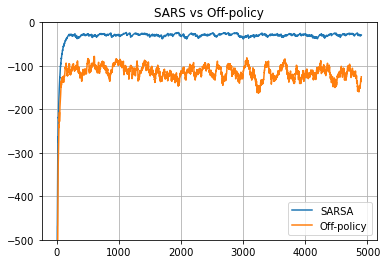

In [158]:
# SARSA agent, Off-policy Q-learning agent학습 후 비교
# 각 agent를 5000번씩 학습후 최종 reward 비교 분석
# Credit: Coursera Practical Reinforcement Learning SARSA learning assignment
from IPython.display import clear_output
import pandas as pd

def moving_average(x, span=100):
    return pd.DataFrame({'x': np.asarray(x)}).x.ewm(span=span).mean().values


sarsa_rewards, off_q_rewards = [], []
for it in range(5000): 
    sarsa_rewards.append(agent_training(env,agent_SARSA))
    off_q_rewards.append(agent_training(env,agent_Q_learning))
    
    if it % 100 == 0:
        clear_output(True)
        print(f'Current iteration: {it}, process: {it/5000*100:.2f}%')
        plt.title('SARS vs Off-policy')
        plt.plot(moving_average(sarsa_rewards),label='SARSA')
        plt.plot(moving_average(off_q_rewards),label='Off-policy')
        plt.grid()
        plt.legend()
        plt.ylim(-500,0)
        plt.show()

In [149]:
# rendering
# environment와 agent가 설정되었으니 메인 학습코드를 구성
def agent_playing(env,agent,t_max=10**4):
    '''
    입력인자
        env : 환경 cliff-walking
        agent: SARSA, Off-policy Q-learning agent
        t_max: 인위적으로 에피소드 종료반복회차
    '''
    print('Cliff walking start!')
    s = env.reset() # environment 초기화
    total_reward = 0
    print('')
    for t in range(t_max):
        print(f'Step {t:d}')
        env.render()
        a = agent.get_action(s) # <구현 필! SARSA, Q_learning agent에 맞게 action추출>
        
        new_s, r, done, _ = env.step(a) # agent의 action을 환경에 대입하고 s', R을 관찰
        
        s = new_s
        total_reward += r
        
        if done:
            if s == 47:
                print('Agent succeeded to solve the problem')
            else:
                print('Agent failed to solve the probelem')
            break

In [151]:
# sarsa play
agent_playing(env,agent_SARSA)

Cliff walking start!

Step 0
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
x  C  C  C  C  C  C  C  C  C  C  T

24
Step 1
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
x  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

12
Step 2
o  o  o  o  o  o  o  o  o  o  o  o
x  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

0
Step 3
x  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

1
Step 4
o  x  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

2
Step 5
o  o  x  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

3
Step 6
o  o  o  x  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o

In [152]:
# Off policy Q-learning play
agent_playing(env,agent_Q_learning)

Cliff walking start!

Step 0
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
x  C  C  C  C  C  C  C  C  C  C  T

24
Step 1
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
x  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

25
Step 2
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  x  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

26
Step 3
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  x  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

25
Step 4
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  x  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

26
Step 5
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  x  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

27
Step 6
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  